<a href="https://colab.research.google.com/github/fovi-llc/time_series_transformer/blob/main/StockPricePredictionUsingTransformers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The source of this notebook is (https://colab.research.google.com/drive/1j3AYSIxhiNJSCP692pKPbLk4_-kG4Pmh?usp=sharing) which accompanies this Medium article:  **Stock Price Prediction Using Transformers
Introduction: Evolving Landscape of Stock Price Prediction** (https://medium.com/@Matthew_Frank/stock-price-prediction-using-transformers-2d84341ff213).

Modifications by Jim White (https://www.linkedin.com/in/jamespaulwhite/).

In [ ]:
%pip install python-dotenv

In [ ]:
try:
  from google.colab import data_table
  data_table.enable_dataframe_formatter()
except:
  pass

In [ ]:
def calculate_bollinger_bands(data, window=10, num_of_std=2):
    """Calculate Bollinger Bands"""
    rolling_mean = data.rolling(window=window).mean()
    rolling_std = data.rolling(window=window).std()
    upper_band = rolling_mean + (rolling_std * num_of_std)
    lower_band = rolling_mean - (rolling_std * num_of_std)
    return upper_band, lower_band

def calculate_rsi(data, window=10):
    """Calculate Relative Strength Index"""
    delta = data.diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)
    avg_gain = gain.rolling(window=window, min_periods=1).mean()
    avg_loss = loss.rolling(window=window, min_periods=1).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

def calculate_roc(data, periods=10):
    """Calculate Rate of Change."""
    roc = ((data - data.shift(periods)) / data.shift(periods)) * 100
    return roc

In [ ]:
import math
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Input, Dense, Dropout, LayerNormalization, MultiHeadAttention, Add, GlobalAveragePooling1D


In [ ]:
tickers = ['META', 'AAPL', 'MSFT', 'AMZN', 'GOOG']

In [ ]:
%load_ext dotenv

import os

if not os.environ.get('POLYGON_API_KEY'):
    try:
        from google.colab import userdata
        try:
            from google.colab import errors
            os.environ['POLYGON_API_KEY'] = userdata.get('POLYGON_API_KEY').strip()
        except Exception as ex:
            print(ex)
            pass
        except errors.Error as err:
            print(err)
            pass
    except ModuleNotFoundError:
        pass

    if not os.environ.get('POLYGON_API_KEY'):
        import getpass
        os.environ['POLYGON_API_KEY'] = getpass.getpass('Enter your Polygon API key: ').strip()

    if not os.environ.get('POLYGON_API_KEY'):
        raise ValueError('No Polygon API key provided')


API_KEY = os.getenv('POLYGON_API_KEY')

In [ ]:
import requests
import pandas as pd
import os

# Function to get data from Polygon.io
def get_polygon_data(ticker, api_key, multiplier, timespan, from_date, to_date):
    url = f'https://api.polygon.io/v2/aggs/ticker/{ticker}/range/{multiplier}/{timespan}/{from_date}/{to_date}'
    params = {
        'adjusted': 'true',
        'sort': 'asc',
        'limit': 50000,
        'apiKey': api_key
    }
    response = requests.get(url, params=params)
    data = response.json()
    try:
      df = pd.DataFrame(data['results'])
      df['timestamp'] = pd.to_datetime(df['t'], unit='ms')
      df.set_index('timestamp', inplace=True)
      return df
    except Exception as ex:
      print(f"{ex=}")
      print(f"{response=}")
      return None


ticker_data_frames = []
stats = {}


multiplier=5
timespan="minute"
from_date="2023-03-01"
to_date="2023-08-01"
data_folder = "data"

for ticker in tickers:
    saved_file_name = f'./{ticker}_{multiplier}_{timespan}_{from_date}_{to_date}.csv'
    saved_file_path = os.path.join(data_folder, saved_file_name)
    # Download historical data for the ticker
    if os.path.exists(saved_file_path):
        data = pd.read_csv(saved_file_path)
    else:
        data = get_polygon_data(ticker, api_key=API_KEY, multiplier=multiplier, timespan=timespan, from_date=from_date, to_date=to_date)
        #create a folder if it does not exist
        if not os.path.exists(data_folder):
            os.makedirs(data_folder)
        data.to_csv(saved_file_path)


    # Calculate the daily percentage change
    close = data['c']
    upper, lower = calculate_bollinger_bands(close, window=14, num_of_std=2)
    width = upper - lower
    rsi = calculate_rsi(close, window=14)
    roc = calculate_roc(close, periods=14)
    volume = data['v']
    diff = close.diff(1)
    percent_change_close = close.pct_change() * 100

    # Create a DataFrame for the current ticker and append it to the list
    ticker_df = pd.DataFrame({
        ticker+'_close': close,
        ticker+'_width': width,
        ticker+'_rsi': rsi,
        ticker+'_roc': roc,
        ticker+'_volume': volume,
        ticker+'_diff': diff,
        ticker+'_percent_change_close': percent_change_close,
    })

    MEAN = ticker_df.mean()
    STD = ticker_df.std()

    # Keep track of mean and std
    for column in MEAN.index:
        stats[f"{column}_mean"] = MEAN[column]
        stats[f"{column}_std"] = STD[column]

    # Normalize the training features
    ticker_df = (ticker_df - MEAN) / STD

    ticker_data_frames.append(ticker_df)


In [ ]:
f"{len(ticker_data_frames)=}"

'len(ticker_data_frames)=5'

In [ ]:
ticker_data_frames[3]

AMZN_close  AMZN_width  AMZN_rsi  AMZN_roc  AMZN_volume  AMZN_diff  \
0       -1.140516         NaN       NaN       NaN    -0.612725        NaN   
1       -1.140516         NaN       NaN       NaN    -0.627296  -0.011122   
2       -1.143030         NaN -3.181464       NaN    -0.629513  -0.106546   
3       -1.146800         NaN -3.181464       NaN    -0.629867  -0.154259   
4       -1.155597         NaN -3.181464       NaN    -0.630781  -0.345108   
...           ...         ...       ...       ...          ...        ...   
11969    2.339236    0.364623 -0.670205 -0.472659     0.793267   0.442144   
11970    2.337979    0.450970 -0.579981 -0.396132     0.881762  -0.058834   
11971    2.343634    0.508174 -0.470165 -0.325168     1.562978   0.203583   
11972    2.363113    0.526257 -0.332992 -0.236553     2.922868   0.728417   
11973    2.366883    0.536706 -0.414087 -0.289537     1.724967   0.132015   

       AMZN_percent_change_close  
0                            NaN  
1                      -0.011879  
2                      -0.118658  
3                      -0.172081  
4                      -0.385802  
...                          ...  
11969                   0.381062  
11970                  -0.053209  
11971                   0.174122  
11972                   0.628556  
11973                   0.111920  

[11974 rows x 7 columns]

In [ ]:
# Convert stats from dict to df
stats = pd.DataFrame([stats], index=[0])
stats.head()

META_close_mean  META_close_std  META_width_mean  META_width_std  \
0       227.519071       30.167008         1.850547        1.782767   

   META_rsi_mean  META_rsi_std  META_roc_mean  META_roc_std  META_volume_mean  \
0      50.915102     16.608325       0.052246      0.692626     134819.392285   

   META_volume_std  ...  GOOG_rsi_mean  GOOG_rsi_std  GOOG_roc_mean  \
0    224770.149316  ...       50.56595     16.450917       0.029938   

   GOOG_roc_std  GOOG_volume_mean  GOOG_volume_std  GOOG_diff_mean  \
0      0.548505     144977.639232     243139.17549        0.002113   

   GOOG_diff_std  GOOG_percent_change_close_mean  \
0       0.167916                        0.002144   

   GOOG_percent_change_close_std  
0                       0.153451  

[1 rows x 70 columns]

In [ ]:
# Concatenate all ticker DataFrames
df = pd.concat(ticker_data_frames, axis=1)
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 11960 entries, 14 to 11973
Data columns (total 35 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   META_close                 11960 non-null  float64
 1   META_width                 11960 non-null  float64
 2   META_rsi                   11960 non-null  float64
 3   META_roc                   11960 non-null  float64
 4   META_volume                11960 non-null  float64
 5   META_diff                  11960 non-null  float64
 6   META_percent_change_close  11960 non-null  float64
 7   AAPL_close                 11960 non-null  float64
 8   AAPL_width                 11960 non-null  float64
 9   AAPL_rsi                   11960 non-null  float64
 10  AAPL_roc                   11960 non-null  float64
 11  AAPL_volume                11960 non-null  float64
 12  AAPL_diff                  11960 non-null  float64
 13  AAPL_percent_change_close  11960 non-null  float64

META_close  META_width  META_rsi  META_roc  META_volume  META_diff  \
14   -1.715088   -0.727670  0.088260 -0.009694    -0.596260  -0.406449   
15   -1.715088   -0.730666 -0.112625 -0.100069    -0.597016  -0.019198   
16   -1.709121   -0.709032  0.105226 -0.001548    -0.596696   0.416459   
17   -1.708458   -0.689247  0.088260 -0.009768    -0.593212   0.029208   
18   -1.717408   -0.689469 -0.122000 -0.108292    -0.590663  -0.672685   

    META_percent_change_close  AAPL_close  AAPL_width  AAPL_rsi  ...  \
14                  -0.505622   -1.845881   -0.725981 -0.382709  ...   
15                  -0.019889   -1.847025   -0.722246 -0.033662  ...   
16                   0.527058   -1.844736   -0.741124 -0.194641  ...   
17                   0.040821   -1.845881   -0.738004  0.659708  ...   
18                  -0.839377   -1.837871   -0.824044  1.810158  ...   

    AMZN_volume  AMZN_diff  AMZN_percent_change_close  GOOG_close  GOOG_width  \
14    -0.632497  -0.106546                  -0.118748   -1.788538   -0.756808   
15    -0.625302   0.036590                   0.041567   -1.789450   -0.760097   
16    -0.632133  -0.106546                  -0.118759   -1.780329   -0.672351   
17    -0.631687   0.322863                   0.362281   -1.789450   -0.661847   
18    -0.630687   0.132015                   0.148357   -1.802220   -0.694864   

    GOOG_rsi  GOOG_roc  GOOG_volume  GOOG_diff  GOOG_percent_change_close  
14  0.854021  0.326828    -0.590825   0.106521                   0.129272  
15  0.978712  0.367115    -0.590664  -0.072140                  -0.085574  
16  1.099681  0.447107    -0.589126   0.582949                   0.702157  
17  0.423581  0.166064    -0.595559  -0.608122                  -0.729309  
18  0.199393  0.065890    -0.562981  -0.846336                  -1.016545  

[5 rows x 35 columns]

In [ ]:
df.tail()

META_close  META_width  META_rsi  META_roc  META_volume  META_diff  \
11969    1.455263   -0.802659  0.024022 -0.064793    -0.591793  -0.091808   
11970    1.456257   -0.802020 -0.015012 -0.070113    -0.599031   0.053411   
11971    1.456257   -0.800650  0.156613 -0.048833    -0.599138  -0.019198   
11972    1.464213   -0.748102  0.904690  0.084166    -0.596771   0.561678   
11973    1.454931   -0.756603  0.180304 -0.027540    -0.598845  -0.696888   

       META_percent_change_close  AAPL_close  AAPL_width  AAPL_rsi  ...  \
11969                  -0.078919    1.847752   -0.825341  0.493398  ...   
11970                   0.039148    1.853473   -0.819990  0.450535  ...   
11971                  -0.019889    1.848896   -0.851139  0.450535  ...   
11972                   0.452352    1.847752   -0.891079  0.390526  ...   
11973                  -0.570350    1.850041   -0.908198 -0.406184  ...   

       AMZN_volume  AMZN_diff  AMZN_percent_change_close  GOOG_close  \
11969     0.793267   0.442144                   0.381062    1.351909   
11970     0.881762  -0.058834                  -0.053209    1.337315   
11971     1.562978   0.203583                   0.174122    1.371976   
11972     2.922868   0.728417                   0.628556    1.345068   
11973     1.724967   0.132015                   0.111920    1.351909   

       GOOG_width  GOOG_rsi  GOOG_roc  GOOG_volume  GOOG_diff  \
11969    0.734995  1.488519  1.042020    -0.555960   0.046967   
11970    0.541262  1.284690  0.940388    -0.523509  -0.965443   
11971    0.308033  1.901591  1.658865    -0.490796   2.250448   
11972    0.036166  0.985781  0.873576     2.878147  -1.769416   
11973   -0.278747  1.001665  0.895045     1.745549   0.434065   

       GOOG_percent_change_close  
11969                   0.037986  
11970                  -0.845186  
11971                   1.962693  
11972                  -1.543843  
11973                   0.375897  

[5 rows x 35 columns]

In [ ]:
# Shift the df data to create labels
labels = df.shift(-1)
# Drop the last row in both percent_change_data and labels as it won't have a corresponding label
df = df.iloc[:-1]
labels = labels.iloc[:-1]


In [ ]:
# Sequence len = 24 means that we have 2 hours of 5 min data
SEQUENCE_LEN = 24

# Function to create X-day sequences for each ticker
def create_sequences(data, labels, mean, std, sequence_length=SEQUENCE_LEN):
    sequences = []
    lab = []
    data_size = len(data)

    # -1 because we want to know the last close of the sequence.
    # + 12 because we want to predict the next hour
    for i in range(1, data_size - (sequence_length + 13)):
      sequences.append(data[i:i + sequence_length])
      lab.append([labels[i-1], labels[i + 12], mean[0], std[0]])

    return np.array(sequences), np.array(lab)

In [ ]:
sequences_dict = {}
sequence_labels = {}
for ticker in tickers:

    # Extract close and volume data for the ticker
    close = df[ticker+'_close'].values
    width = df[ticker+'_width'].values
    rsi = df[ticker+'_rsi'].values
    roc = df[ticker+'_roc'].values
    volume = df[ticker+'_volume'].values
    diff = df[ticker+'_diff'].values
    pct_change = df[ticker+'_percent_change_close'].values

    # Combine close and volume data
    ticker_data = np.column_stack((close,
                                   width,
                                   rsi,
                                   roc,
                                   volume,
                                   diff,
                                   pct_change))

    # Generate sequences
    attribute = ticker+"_close"
    ticker_sequences, lab = create_sequences(ticker_data,
                                             labels[attribute].values[SEQUENCE_LEN-1:],
                                             stats[attribute+"_mean"].values,
                                             stats[attribute+"_std"].values)

    sequences_dict[ticker] = ticker_sequences
    sequence_labels[ticker] = lab

In [ ]:
sequences_dict['META'].shape

(11921, 24, 7)

In [ ]:
sequences_dict['META'][0][-1]

array([-1.74425885, -0.60648575, -0.92754074, -0.65915946, -0.56331498,
        0.1018175 ,  0.13284914])

In [ ]:
sequence_labels['META'].shape

(11921, 4)

In [ ]:
sequence_labels['META'][0]

array([ -1.74425885,  -1.76348515, 227.51907105,  30.16700829])

In [68]:
# Combine data and labels from all tickers

TRAIN_FRACTION = 0.8

train_sequences = []
train_labels = []
other_sequences = []
other_labels = []

def extend_sequences(ticker):
  ticker_sequence = sequences_dict[ticker]
  ticker_labels = sequence_labels[ticker]
  seq_len = len(ticker_sequence)
  assert seq_len == len(ticker_labels)
  train_len = int(seq_len * TRAIN_FRACTION)
  train_sequences.extend(ticker_sequence[:train_len])
  train_labels.extend(ticker_labels[:train_len])
  # Leave a gap between the train and other splits so they don't overlap in time.
  other_sequences.extend(ticker_sequence[train_len + SEQUENCE_LEN:])
  other_labels.extend(ticker_labels[train_len + SEQUENCE_LEN:])


for ticker in tickers:
    extend_sequences(ticker)

# Convert to numpy arrays
train_sequences = np.array(train_sequences)
train_labels = np.array(train_labels)
other_sequences = np.array(other_sequences)
other_labels = np.array(other_labels)

print(f"{train_sequences.shape=}")
print(f"{train_labels.shape=}")
print(f"{other_sequences.shape=}")
print(f"{other_labels.shape=}")

train_sequences.shape=(47680, 24, 7)
train_labels.shape=(47680, 4)
other_sequences.shape=(11805, 24, 7)
other_labels.shape=(11805, 4)


In [69]:
np.random.seed(42)

# Randomize the order of the training data
shuffled_indices = np.random.permutation(len(train_sequences))
train_sequences = train_sequences[shuffled_indices]
train_labels = train_labels[shuffled_indices]

# Validation/Test split is 50/50
val_size = int(len(other_sequences) * 0.5)

validation_sequences = other_sequences[:val_size]
validation_labels = other_labels[:val_size]

# Leave a gap between the val and test splits so they don't overlap in time.
test_sequences = other_sequences[val_size + SEQUENCE_LEN:]
test_labels = other_labels[val_size + SEQUENCE_LEN:]

print(f"{validation_sequences.shape=}")
print(f"{validation_labels.shape=}")
print(f"{test_sequences.shape=}")
print(f"{test_labels.shape=}")

validation_sequences.shape=(5902, 24, 7)
validation_labels.shape=(5902, 4)
test_sequences.shape=(5879, 24, 7)
test_labels.shape=(5879, 4)


In [ ]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Attention and Normalization
    x = LayerNormalization(epsilon=1e-6)(inputs)
    x = MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(x, x)
    x = Add()([x, inputs])

    # Feed Forward Part
    y = LayerNormalization(epsilon=1e-6)(x)
    y = Dense(ff_dim, activation="relu")(y)
    y = Dropout(dropout)(y)
    y = Dense(inputs.shape[-1])(y)
    return Add()([y, x])

def build_transformer_model(input_shape, head_size, num_heads, ff_dim, num_layers, dropout=0):
    inputs = Input(shape=input_shape)
    x = inputs

    # Create multiple layers of the Transformer block
    for _ in range(num_layers):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    # Final part of the model
    x = GlobalAveragePooling1D()(x)
    x = LayerNormalization(epsilon=1e-6)(x)
    outputs = Dense(1, activation="linear")(x)

    # Compile model
    model = Model(inputs=inputs, outputs=outputs)
    return model

# Model parameters
input_shape = train_sequences.shape[1:]
head_size = 256
num_heads = 16
ff_dim = 1024
num_layers = 12
dropout = 0.20

# Build the model
model = build_transformer_model(input_shape, head_size, num_heads, ff_dim, num_layers, dropout)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 24, 7)]              0         []                            
                                                                                                  
 layer_normalization (Layer  (None, 24, 7)                14        ['input_1[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 multi_head_attention (Mult  (None, 24, 7)                126983    ['layer_normalization[0][0]', 
 iHeadAttention)                                                     'layer_normalization[0][0]'] 
                                                                                              

In [ ]:
def custom_mae_loss(y_true, y_pred):
    y_true_next = tf.cast(y_true[:, 1], tf.float64)
    y_pred_next = tf.cast(y_pred[:, 0], tf.float64)
    abs_error = tf.abs(y_true_next - y_pred_next)

    return tf.reduce_mean(abs_error)

def dir_acc(y_true, y_pred):
    mean, std = tf.cast(y_true[:, 2], tf.float64), tf.cast(y_true[:, 3], tf.float64)

    y_true_prev = (tf.cast(y_true[:, 0], tf.float64) * std) + mean
    y_true_next = (tf.cast(y_true[:, 1], tf.float64) * std) + mean
    y_pred_next = (tf.cast(y_pred[:, 0], tf.float64) * std) + mean

    true_change = y_true_next - y_true_prev
    pred_change = y_pred_next - y_true_prev

    correct_direction = tf.equal(tf.sign(true_change), tf.sign(pred_change))

    return tf.reduce_mean(tf.cast(correct_direction, tf.float64))

In [ ]:
# Compile the model
optimizer = tf.keras.optimizers.Adam()
model.compile(optimizer=optimizer, loss=custom_mae_loss, metrics=[dir_acc])

In [ ]:
import matplotlib.pyplot as plt
# Define a callback to save the best model
checkpoint_callback_train = ModelCheckpoint(
    "transformer_train_model.keras",  # Filepath to save the best model
    monitor="dir_acc",  #"loss",  # Metric to monitor
    save_best_only=True,  # Save only the best model
    mode="max",  # Minimize the monitored metric
    verbose=1,  # Display progress
)

# Define a callback to save the best model
checkpoint_callback_val = ModelCheckpoint(
    "transformer_val_model.keras",  # Filepath to save the best model
    monitor="val_dir_acc", #"val_loss",  # Metric to monitor
    save_best_only=True,  # Save only the best model
    mode="max",  # Minimize the monitored metric
    verbose=1,  # Display progress
)

def get_lr_callback(batch_size=16, mode='cos', epochs=500, plot=False):
    lr_start, lr_max, lr_min = 0.0001, 0.005, 0.00001  # Adjust learning rate boundaries
    lr_ramp_ep = int(0.30 * epochs)  # 30% of epochs for warm-up
    lr_sus_ep = max(0, int(0.10 * epochs) - lr_ramp_ep)  # Optional sustain phase, adjust as needed

    def lrfn(epoch):
        if epoch < lr_ramp_ep:  # Warm-up phase
            lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start
        elif epoch < lr_ramp_ep + lr_sus_ep:  # Sustain phase at max learning rate
            lr = lr_max
        elif mode == 'cos':
            decay_total_epochs, decay_epoch_index = epochs - lr_ramp_ep - lr_sus_ep, epoch - lr_ramp_ep - lr_sus_ep
            phase = math.pi * decay_epoch_index / decay_total_epochs
            lr = (lr_max - lr_min) * 0.5 * (1 + math.cos(phase)) + lr_min
        else:
            lr = lr_min  # Default to minimum learning rate if mode is not recognized

        return lr

    if plot:  # Plot learning rate curve if plot is True
        plt.figure(figsize=(10, 5))
        plt.plot(np.arange(epochs), [lrfn(epoch) for epoch in np.arange(epochs)], marker='o')
        plt.xlabel('Epoch')
        plt.ylabel('Learning Rate')
        plt.title('Learning Rate Scheduler')
        plt.show()

    return tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=True)

In [ ]:
BATCH_SIZE = 64
# EPOCHS = 100
EPOCHS = 50
model.fit(train_sequences, train_labels,
          validation_data=(validation_sequences, validation_labels),
          epochs=EPOCHS,
          batch_size=BATCH_SIZE,
          shuffle=True,
          callbacks=[checkpoint_callback_train, checkpoint_callback_val, get_lr_callback(batch_size=BATCH_SIZE, epochs=EPOCHS)])


Epoch 1: LearningRateScheduler setting learning rate to 0.0001.
Epoch 1/50
745/745 [==============================] - ETA: 0s - loss: 0.1312 - dir_acc: 0.5042
Epoch 1: dir_acc improved from -inf to 0.50424, saving model to transformer_train_model.keras

Epoch 1: val_dir_acc improved from -inf to 0.50572, saving model to transformer_val_model.keras
745/745 [==============================] - 96s 87ms/step - loss: 0.1312 - dir_acc: 0.5042 - val_loss: 0.1172 - val_dir_acc: 0.5057 - lr: 1.0000e-04

Epoch 2: LearningRateScheduler setting learning rate to 0.00042666666666666667.
Epoch 2/50
745/745 [==============================] - ETA: 0s - loss: 0.1182 - dir_acc: 0.5058
Epoch 2: dir_acc improved from 0.50424 to 0.50579, saving model to transformer_train_model.keras

Epoch 2: val_dir_acc did not improve from 0.50572
745/745 [==============================] - 62s 83ms/step - loss: 0.1182 - dir_acc: 0.5058 - val_loss: 0.2760 - val_dir_acc: 0.4901 - lr: 4.2667e-04

Epoch 3: LearningRateSchedul

In [ ]:
# Load Weights
model.load_weights("transformer_val_model.keras")

# Make predictions
evaluation = model.evaluate(test_sequences, test_labels)
print(f"directional accuracy={evaluation[1]}")
print(model.metrics_names)
print(evaluation)

# Calculate additional metrics as needed
from sklearn.metrics import r2_score

predictions = model.predict(test_sequences)
r2 = r2_score(test_labels[:, 1], predictions[:, 0])
print(f"R-squared: {r2}")

184/184 [==============================] - 4s 21ms/step - loss: 0.2212 - dir_acc: 0.4929
directional accuracy=0.49294808506965637
['loss', 'dir_acc']
[0.22123047709465027, 0.49294808506965637]
184/184 [==============================] - 5s 21ms/step
R-squared: 0.10997434544317042


In [ ]:
results = pd.DataFrame({'actual':test_labels[:, 1], 'predicted':predictions[:, 0], 'error_ratio':(abs(predictions[:, 0] - test_labels[:, 1]))/test_labels[:, 1]})
results

actual  predicted  error_ratio
0     1.319579   1.395435     0.057485
1     1.314319   1.406538     0.070165
2     1.321082   1.437587     0.088189
3     1.312440   1.464501     0.115861
4     1.325591   1.452878     0.096023
...        ...        ...          ...
5874  1.356469   1.468838     0.082839
5875  1.350997   1.455456     0.077320
5876  1.351909   1.431049     0.058540
5877  1.337315   1.414438     0.057670
5878  1.371976   1.329945     0.030635

[5879 rows x 3 columns]

from matplotlib import pyplot as plt
results['actual'].plot(kind='hist', bins=20, title='actual')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
results['predicted'].plot(kind='hist', bins=20, title='predicted')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
results['error_ratio'].plot(kind='hist', bins=20, title='error_ratio')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
results.plot(kind='scatter', x='actual', y='predicted', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
results.plot(kind='scatter', x='predicted', y='error_ratio', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
results['actual'].plot(kind='line', figsize=(8, 4), title='actual')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
results['predicted'].plot(kind='line', figsize=(8, 4), title='predicted')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
results['error_ratio'].plot(kind='line', figsize=(8, 4), title='error_ratio')
plt.gca().spines[['top', 'right']].set_visible(False)

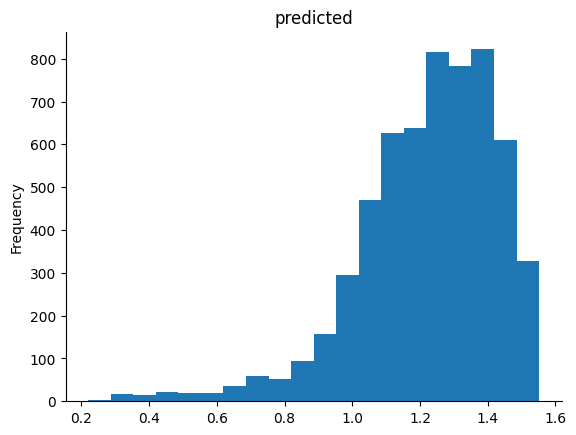

In [ ]:
# @title predicted

from matplotlib import pyplot as plt
results['predicted'].plot(kind='hist', bins=20, title='predicted')
plt.gca().spines[['top', 'right',]].set_visible(False)

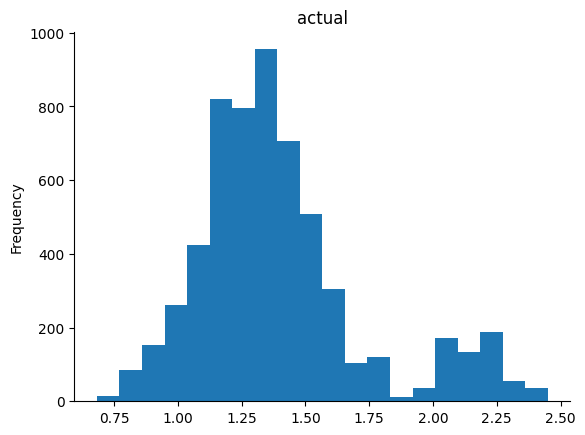

In [ ]:
# @title actual

from matplotlib import pyplot as plt
results['actual'].plot(kind='hist', bins=20, title='actual')
plt.gca().spines[['top', 'right',]].set_visible(False)

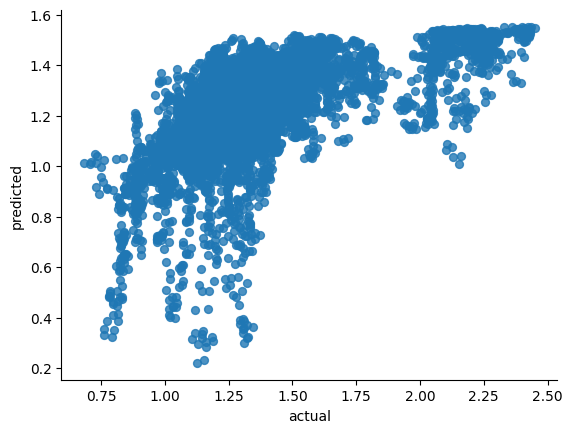

In [ ]:
# @title actual vs predicted

from matplotlib import pyplot as plt
results.plot(kind='scatter', x='actual', y='predicted', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)